<p style="width:100%;color:#B71C1C;font-size:28px;text-align:justify"> Calculation of melting temperature </p> 

In this notebook, we will use interatomic potentials for the calculation of thermodynamic properties such as Helmholtz and Gibbs free energies, which in turn can be used for the calculation of phase diagrams. We will discuss calphy, the tool for automated calculation of free energies, and the methology involved. As a first step, we will calculate the melting temperature of Copper. A brief introduction to the tools.

<table border="0">
 <tr>
    <td style="width:60%"> <p style="width:100% color:gray;font-size:24px;text-align:right"> <a href="https://github.com/pyiron/pyiron_atomistics">pyiron-atomistics</a> provides integrations for atomistics tools enabling seamless cross-code workflows from jupyter notebooks.</p> </td>
    <td style="width:40%"><img src="img/logo.png" width="50%" align="justify"></td>
  </tr>
</table>

<table border="0">
 <tr>
    <td style="width:40%"><img src="img/calphy_logo.png" width="100%" align="justify"></td>
    <td style="width:60%"> <p style="width:100% color:gray;font-size:18px;text-align:justify"> Calphy is a Python code for automated calculation of free energies. It enables calculation of Helmholtz and Gibbs free energy for both solid and liquid phases at the given thermodynamic conditions using automated protocols </p> </td>
 </tr>
</table>

This notebook **runs** the calculations. If you would like to instead explore the results, please see notebook [`example_explore.ipynb`](example_explore.ipynb). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from pyiron_atomistics import Project

Create a project

In [3]:
pr = Project('melting_temperature')

First create an FCC structure

In [4]:
structure = pr.create.structure.ase.bulk('Cu', cubic=True).repeat(4)

Now we will calculate the free energy of the solid structure. The experimental melting temperature is 1358 K, so we will choose the range of 1200-1500 K for calculating the free energy for solid and liquid structures. First the solid structure.

In [5]:
sol = pr.create.job.Calphy("tm_cu_sol")
sol.structure = structure
sol.potential = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1"

The EAM potential we will use is : [Mishin, Y., M. J. Mehl, D. A. Papaconstantopoulos, A. F. Voter, and J. D. Kress. “Structural Stability and Lattice Defects in Copper: Ab Initio , Tight-Binding, and Embedded-Atom Calculations.” Physical Review B 63, no. 22 (May 21, 2001): 224106.](https://doi.org/10.1103/PhysRevB.63.224106)

In [6]:
sol.server.cores = 2
sol.calc_free_energy(temperature=[1200, 1500], 
                     pressure=0, 
                     reference_phase="solid",
                     n_equilibration_steps=5000,
                     n_switching_steps=5000)

Before we actually run the calculation, let us discuss the various parameters. `temperature` keyword gives the temperature range over which the free energy is to be calculated. `pressure` denotes the pressure of the calculation, we chose 0 in this case. Since we are using a solid FCC lattice, we set `reference_phase` to `"solid"`. This means that the Einstein crystal will be used as the reference system. Finally, we have `n_equilibration_steps` and `n_switching_steps`. `n_equilibration_steps` denotes the number of MD steps over which the system is equilibrated to the required temperature and pressure. `n_switching_steps` are the number of MD steps over which the system is continuously transformed between the given interatomic potential, and the reference Einstein crystal.

Now we run the job

In [7]:
sol.run()

The job tm_cu_sol was saved and received the ID: 203


Now we run the calculation for the liquid system

In [8]:
lqd = pr.create.job.Calphy("tm_cu_lqd")
lqd.structure = structure
lqd.potential = "2001--Mishin-Y--Cu-1--LAMMPS--ipr1"
lqd.server.cores = 2
lqd.calc_free_energy(temperature=[1200, 1500], 
                     pressure=0, 
                     reference_phase="liquid",
                     n_equilibration_steps=5000,
                     n_switching_steps=5000)

In [9]:
lqd.run()

The job tm_cu_lqd was saved and received the ID: 204


Now we look at the results

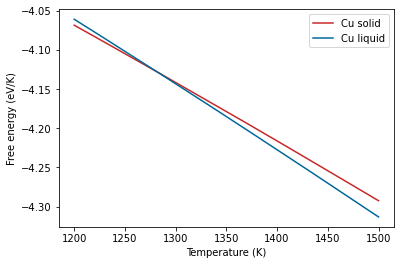

In [10]:
plt.plot(sol.output.temperature, sol.output.energy_free,
        label="Cu solid", color='#C62828')
plt.plot(lqd.output.temperature, lqd.output.energy_free,
        label="Cu liquid", color='#006899')
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy (eV/K)")
plt.legend();

The melting temperature is defined as the temperature at which the free energy difference between the solid and liquid phases is zero. We can also plot the free energy difference directly.

In [11]:
fediff = sol.output.energy_free - lqd.output.energy_free

Find where the value is zero and get the corresponding temperature

In [12]:
arg = np.argsort(np.abs(fediff))[0]
tm = sol.output.temperature[arg]
tm

1281.722635221738

The calculated melting temperature is shown above.

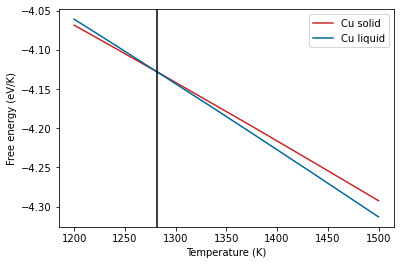

In [13]:
plt.plot(sol.output.temperature, sol.output.energy_free,
        label="Cu solid", color='#C62828')
plt.plot(lqd.output.temperature, lqd.output.energy_free,
        label="Cu liquid", color='#006899')
plt.axvline(tm, color="black")
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy (eV/K)")
plt.legend();

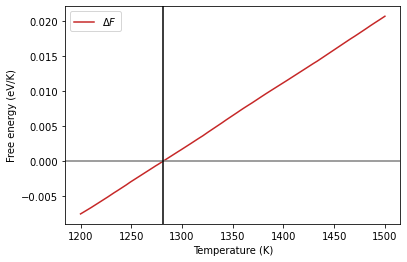

In [14]:
plt.plot(sol.output.temperature, fediff,
        label=r"$\Delta F$", color='#C62828')
plt.axhline(0, color="gray")
plt.axvline(tm, color="black")
plt.xlabel("Temperature (K)")
plt.ylabel("Free energy (eV/K)")
plt.legend();

In [5]:
pr.pack(destination_path="pyiron/calculation/save")